## 第３章　分類問題 - scikit-learnの活用
- ロジスティック回帰、SVM、決定木
- 線形及び非線形の決定境界をもつ分類器の長所と短所

In [9]:
from sklearn import datasets
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from distutils.version import LooseVersion

### 3-1 パーセプトロンの訓練

In [3]:
# irisのデータをインポート
iris = datasets.load_iris()
# ３つ目と４つ目の特徴量だけ抽出
X = iris.data[:,[2,3]]
y = iris.target
# sklearnではメモリを抑えて計算性能を向上させるために整数のラベルを使うことが推奨されている。
print(np.unique(y))

[0 1 2]


In [4]:
# stratify=yで訓練データとテストデータのクラスラベルの比率を同じにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print('Labels count in y:', np.bincount(y))
print('Labels count in y_train:', np.bincount(y_train))
print('Labels count in y_test:', np.bincount(y_test))

Labels count in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


In [6]:
#　評価指標の正答率の出し方は以下の２通り
print(accuracy_score(y_test,y_pred))
print(ppn.score(X_test_std,y_test))

0.9777777777777777
0.9777777777777777


In [7]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')        

/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_219/1719824954.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


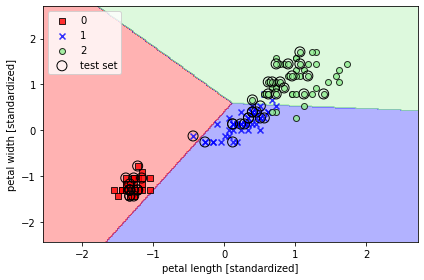

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

###  3-3 ロジスティック回帰を使ってクラスの確率を予測するモデルの構築
- パーセプトロンモデルでは、クラスを完全に線形分離できない場合は、決して収束しないこと。

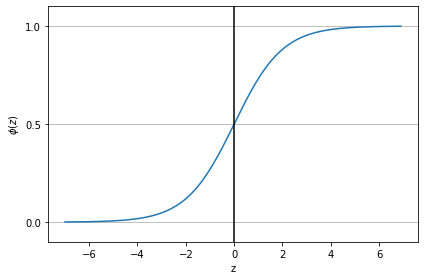

In [11]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('images/03_02.png', dpi=300)
plt.show()

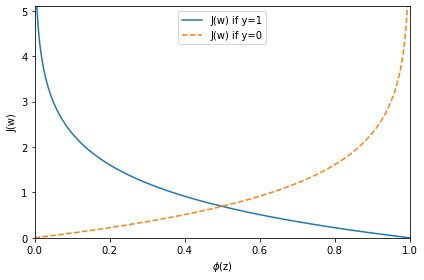

In [12]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_04.png', dpi=300)
plt.show()

### 3.3.4　sklearnを使ったロジスティック回帰モデルの学習

/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_219/1719824954.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


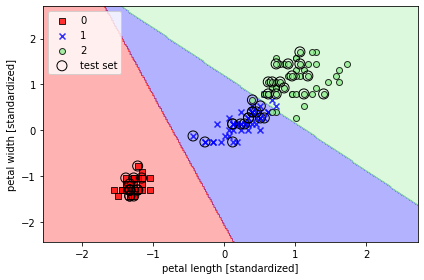

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100,random_state=0,solver='lbfgs',multi_class='ovr')
lr.fit(X_train_std,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier=lr,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_06.png', dpi=300)
plt.show()

In [14]:
# 最初の３つのデータの予測確率を確認する
lr.predict_proba(X_test_std[:3])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [15]:
# 各行の最も大きい列を特定できる
print(lr.predict_proba(X_test_std[:10]).argmax(axis=1))
# predictで呼び出す方が楽
print(lr.predict(X_test_std[:10]))

[2 0 0 1 1 1 2 1 2 0]
[2 0 0 1 1 1 2 1 2 0]


In [16]:
# 単一のデータ点のクラスラベルを予測したい場合は、２次元配列となっていること
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### 3-3-5正則化による過学習への対応　
- 正則化をする際は特徴量が比較可能な尺度になっていること
- ロジスティック回帰で正則化を適用するには、コスト関数に対して正則化項を追加する必要あり（LogisticRegression(c=で制御可能)）

In [17]:
lr.coef_

array([[-5.83037767, -4.98273149],
       [ 2.4099601 , -2.07349026],
       [10.58756396,  5.80486652]])

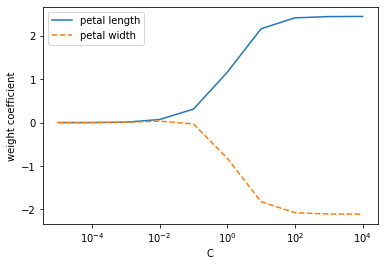

In [18]:
# からのリストを作成（重み、逆正則化パラメータ）
# 本来正則化項は、λで表されるが、C=1/λの関係となっているので、正則化項を大きくするとCが小さくなる
# つまり、逆正則化パラメータCの値を減らすことは、正則化の強さを高めることを意味する
weights,params=[],[]
# １０個の逆正則化パラメータに対するロジスティック回帰を処理
for c in range(-5,5):
    lr = LogisticRegression(C=10.**c,random_state=1,multi_class='ovr')
    lr.fit(X_train_std,y_train)
    #重み係数を格納
    weights.append(lr.coef_[1])
    #逆正則化パラメータを格納
    params.append(10.**c)
    
#重み係数をNumpy配列に変換
weights = np.array(weights)
#横軸に逆正則化パラメータ、縦軸に重み係数をプロット
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('images/03_08.png', dpi=300)
plt.show()
#パラメータCが減少し、正則化の強さが増すと重み係数が０に近づいていることがわかる

### 3−４　SVMによるマージン最大化分類
- SVMの目的は超平面と超平面に最も近い訓練データのマージンの距離を最大化することにある（このデータをサポートベクトルと呼ぶ）
- svmのパラメータCは誤分類のペナルティの寛容さを表しており値が大きいと誤分類のペナルティが大きくなり小さいと誤分類に対して寛容になる
- Cを大きくするとバイアスは低くなるが、バリアンスが高くなり、Cを小さくするとバイアスは大きくなるが、バリアンスが低くなる

### 3-4-3 sklearnでの実施

/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_219/1719824954.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


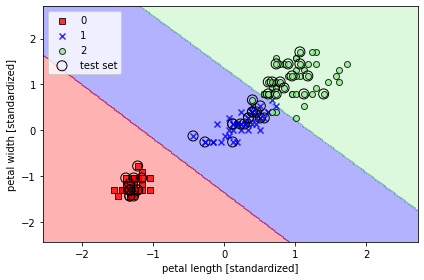

In [19]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_11.png', dpi=300)
plt.show()

#### 分類タスクにおいて、線形ロジスティック回帰と線形SVMは似たようになることが多い。ロジスティック回帰は訓練データの条件付尤度を最大化しようとする。そのため、svmより外れ値の影響を受けやすくなる。一方、svmの主たる関心は決定境界に最も近い点にある。ロジスティック回帰は簡単に更新できるので、ストリーミングデータを扱うときに魅力的である

### 3-5　カーネルsvmを使った非線形問題
- 線形分類不可能なデータに対するカーネル手法

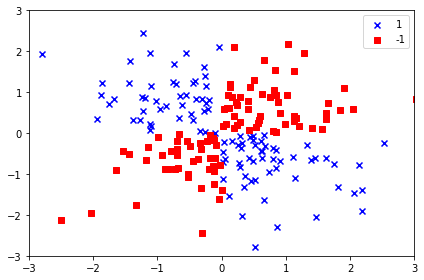

In [21]:
#乱数シード値の指定
np.random.seed(1)
#標準正規分布に従う乱数で２００行列のデータを生成
X_xor = np.random.randn(200,2)
#２つの引数に対して排他的論理和を実行
y_xor = np.logical_xor(X_xor[:,0]>0,X_xor[:,1]>0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_12.png', dpi=300)
plt.show()

- ２平面のデータセットを３次元の特徴量空間に変換することでクラスを分離している
- 純粋に射影すると計算コストはめちゃくちゃ高くなるが、、カーネルトリックを使うことでその問題を解決できる

/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


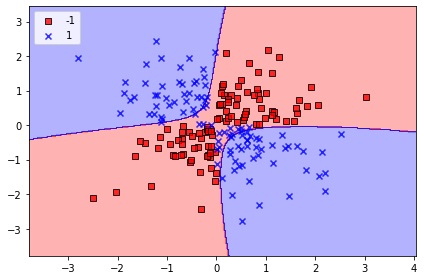

In [22]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_14.png', dpi=300)
plt.show()

/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_219/1719824954.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


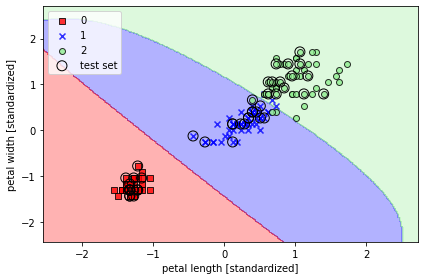

In [23]:
# アイリスのデータを使って非線形分類
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_15.png', dpi=300)
plt.show()


/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_219/1719824954.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


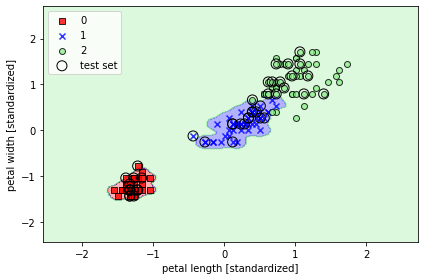

In [24]:
# γを大きくするとクラス０と１の周りの決定境界が複雑になる
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_16.png', dpi=300)
plt.show()

### 3−6 決定木
- criterion=で分割の指標を選択できる

/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_219/1719824954.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


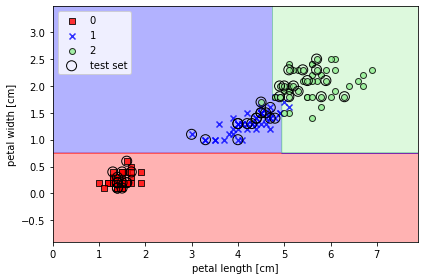

In [25]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4, random_state=1)
#　学習
tree_model.fit(X_train,y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()

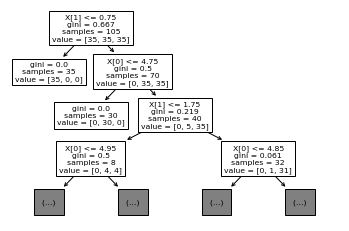

In [26]:
# 決定木の可視化
from sklearn import tree
tree.plot_tree(tree_model,max_depth=3)
plt.show()

### 3-6-3 ランダムフォレストで複数の決定木を結合する
1.サイズnのランダムなブートストラップを復元抽出する  
2.標本から決定機を成長させる  
 2-1 d個の特徴量をランダムに非復元抽出する  
 2-2 例えば情報利得を最大化することによって、目的関数に従って最適な分割となる特徴量を使ってノードを分割する  
3.手順１〜２をk回繰り返す  

/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_219/1719824954.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


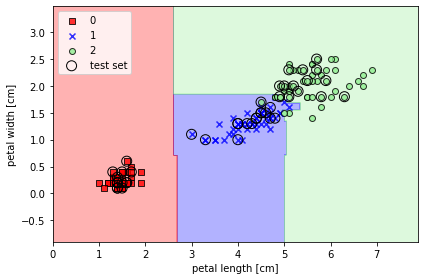

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_22.png', dpi=300)
plt.show()

### 3−７ k最近傍法：怠惰学習アルゴリズム
- 怠惰学習とは、訓練データから判別関数を学習せず、訓練データセットを暗記するため
- kの値と距離指標を選択する
- 分類したいデータ点からkこの最近b法のデータ点を見つけ出す
- 多数決によりクラスラベルを当てる

/tmp/ipykernel_219/1719824954.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipykernel_219/1719824954.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


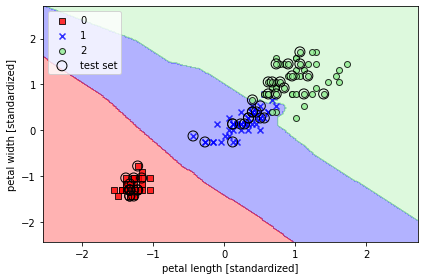

In [28]:
from sklearn.neighbors import KNeighborsClassifier
# minkowskiはユークリッド距離とマンハッタン距離を一般化しタモの
knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()

#### knnは次元の呪いに陥りやすい。高次元の空間では最も近い近傍でも離れすぎていてうまく推定できないことが想像できる。正則化を適用できない決定木やknnは特徴量選択と次元削減手法を使うことで次元の呪いから逃れることができる（次章で解説）